In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import pandas as pd
import geopandas as gpd

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
yy_s = 2001
yy_e = 2013

resolution = '3h'
tscale = 24

In [3]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy','Veneto.geojson')
VENETO = gpd.read_file(veneto_dir)

In [4]:
satellite_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')
data_dir = os.path.join(satellite_dir, 'IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29.nc')

DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

DATA = DATA.sel(lat=slice(44.85,45.15), lon=slice(12.1,12.45))

lons = DATA.lon.values
lats = DATA.lat.values

lon2d_ref, lat2d_ref = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.round(np.abs(lons[1] - lons[0]),2)
dy = np.round(np.abs(lats[1] - lats[0]),2)

ntime = len(DATA['time'])

print(dx)
print(dy)

DATA

0.1
0.1


<xarray.Dataset> Size: 646kB
Dimensions:  (time: 4748, lat: 4, lon: 4)
Coordinates:
  * time     (time) datetime64[ns] 38kB 2001-01-01 2001-01-02 ... 2013-12-31
  * lat      (lat) float64 32B 44.85 44.95 45.05 45.15
  * lon      (lon) float32 16B 12.15 12.25 12.35 12.45
Data variables:
    PRE      (time, lat, lon) float64 608kB ...
Attributes:
    description:  IMERG daily data for Italy region

In [5]:
rain_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','stations','data','Veneto')
RAIN = pd.read_csv(os.path.join(rain_dir, 'QC_stations_coords_utm32.csv'), sep=';')

CL_INFO = RAIN[RAIN['File_Name']=='338_RO_Co.csv']

CL_RAIN = pd.read_csv(os.path.join(rain_dir, 'Dati_QC_30min', CL_INFO['File_Name'].values[0]), sep=';')
CL_RAIN['dataora'] = pd.to_datetime(CL_RAIN['dataora'])
CL_RAIN['yy'] = pd.to_datetime(CL_RAIN['dataora']).dt.year
CL_RAIN['mm'] = pd.to_datetime(CL_RAIN['dataora']).dt.month
CL_RAIN['dd'] = pd.to_datetime(CL_RAIN['dataora']).dt.day

CL_RAIN[CL_RAIN['valore']>200] = 0

CL_RAIN = CL_RAIN[(CL_RAIN['yy']>=yy_s)&(CL_RAIN['yy']<=yy_e)]
CL_RAIN_daily = CL_RAIN.groupby(['yy', 'mm', 'dd'])['valore'].sum().reset_index()
CL_RAIN_daily

,yy,mm,dd,valore
0,2001,1,1,0.0
1,2001,1,2,0.6
2,2001,1,3,1.8
3,2001,1,4,4.0
4,2001,1,5,0.2
...,...,...,...,...
4743,2013,12,27,0.0
4744,2013,12,28,0.4
4745,2013,12,29,0.4
4746,2013,12,30,0.0


In [6]:
lon_OBS = CL_INFO['Lon'].values[0]
lat_OBS = CL_INFO['Lat'].values[0]

In [7]:
# clat = (45.05 + 44.95)/2
# clat = (44.95 + 44.85)/2
# clon = 12.199999809265137

clat = lats[1]
clon = lons[1]

In [8]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3
Tr = np.array([10, 20, 50, 100])
nyears = len(Tr)

In [9]:
L1 = down.area_lat_long(clat, clon, dy, dx)[0] # in Km

In [10]:
dset = np.swapaxes(DATA['PRE'],0,2)
# x = da.from_array(dset, chunks=(4, 4, 800))
xrs0 = xr.DataArray(dset,  coords={'lon':lons, 'lat':lats, 'time':DATA['time'][:]},
                                                    dims=('lon', 'lat', 'time'))
xrs = xrs0.where(xrs0 >= -0.001)

In [11]:
npix = 3

buffer = 0.50*npix*dx
eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
eps = 0
solat = clat - buffer + eps
nolat = clat + buffer + eps
ealon = clon + buffer + eps
welon = clon - buffer + eps
bcond = np.logical_and(
            np.logical_and( xrs.lat > solat, xrs.lat < nolat),
            np.logical_and( xrs.lon > welon, xrs.lon < ealon))

box_3h = xrs.where(bcond, drop = True).load()

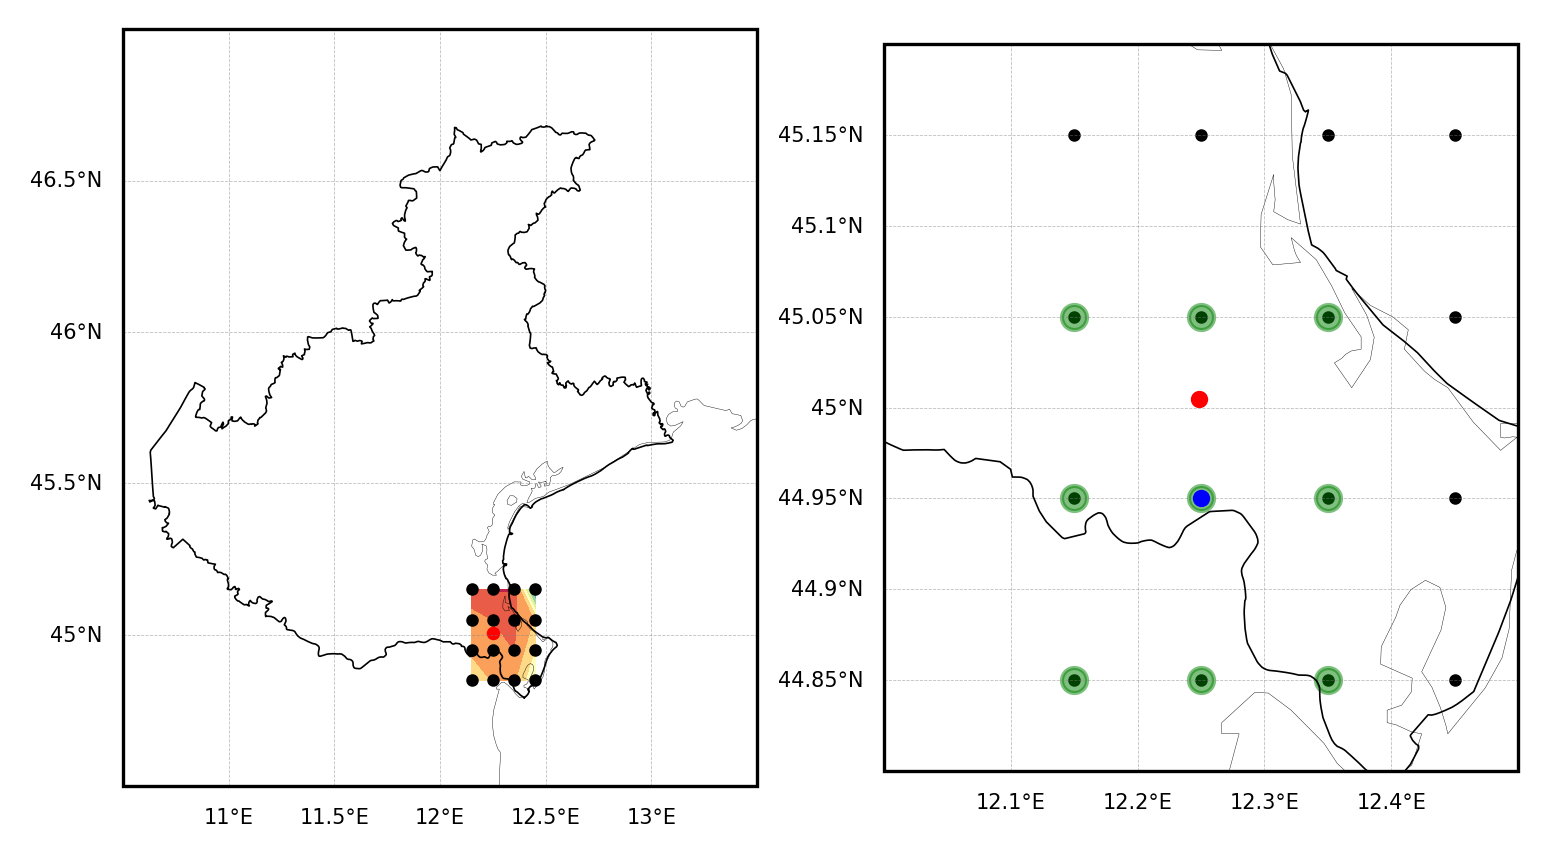

In [12]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.5, 44.5, 47], crs=proj)
VENETO.plot(edgecolor='k', color='None', linewidth=0.4, zorder=10, ax=ax1)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.mean(DATA['PRE'].values,axis=0), cmap=cmap)
ax1.scatter(lon2d_ref, lat2d_ref, s=4, c='k')
ax1.scatter(lon_OBS,lat_OBS,s=5, color='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([12, 12.5, 45.2, 44.8], crs=proj)
VENETO.plot(edgecolor='k', color='None', linewidth=0.4, zorder=10, ax=ax1)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
# a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.mean(DATA['PRE'].values,axis=0), cmap=cmap)

# ax1.add_patch(mpatches.Circle(xy=[clon, clat], radius=buffer, color='red', alpha=0.3, transform=proj, zorder=30))

ax1.scatter(clon,clat,s=10, color='b', zorder=20)

ax1.scatter(lon2d_ref, lat2d_ref, s=4, c='k')
ax1.scatter(lon_OBS,lat_OBS,s=10, color='r')

lon_tmp, lat_tmp = np.meshgrid(box_3h['lon'].values, box_3h['lat'].values)
# ax1.scatter(box_3h['lon'].values, box_3h['lat'].values, c='g', alpha=0.5)
ax1.scatter(lon_tmp, lat_tmp, c='g', alpha=0.5)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

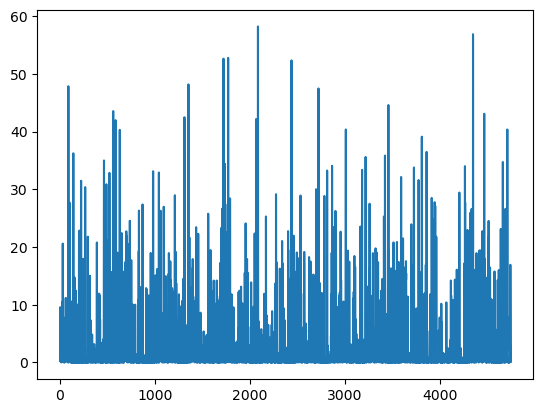

In [17]:
plt.plot(np.mean(box_3h,axis=(0,1)))

In [14]:
pwets, xscales, tscales = down.compute_pwet_xr(box_3h, thresh,
                                    cube1size=3, dt=3, tmax=48)

In [16]:
pwets, xscales, tscales, thresh

(array([[0.32289619, 0.32877001, 0.33277169],
        [0.32289619, 0.32877001, 0.33277169],
        [0.32289619, 0.32877001, 0.33277169],
        [0.32289619, 0.32877001, 0.33277169],
        [0.32289619, 0.32877001, 0.33277169],
        [0.32289619, 0.32877001, 0.33277169],
        [0.32289619, 0.32877001, 0.33277169],
        [0.36451934, 0.37203791, 0.37651395],
        [0.41095313, 0.41753555, 0.42243286],
        [0.49962557, 0.50758214, 0.51095198]]),
 array([1, 2, 3]),
 array([ 3,  6,  9, 12, 15, 18, 24, 30, 36, 48]),
 1)

In [54]:
# L0 = 0.0001 # 1 m
L0 = 0.001 # 10 m
#L0 = 0.01 # 100 m

downres = down.downscale(box_3h, Tr, thresh=thresh, L0=0.0001, toll=toll,
                                acf=acf, save_yearly=True,tscale=24,dt=24,
                                maxmiss=50, clat=clat, clon=clon,
                                opt_method=opt_method, plot=True)

Downscaling Intermittency
Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 0.00022423775847166057
differential_evolution step 2: f(x)= 0.0001088859179268056
differential_evolution step 3: f(x)= 0.0001088859179268056
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters


In [38]:
downres

{'NYs': array([128., 143.,  99., 125., 115., 101., 105., 116., 125., 139.,  87.,
        103., 140.]),
 'CYs': array([4.05441142, 6.39899277, 4.76998297, 6.10372744, 5.66308699,
        4.29858479, 5.23260156, 5.81095179, 5.60452385, 7.32153373,
        5.19128326, 5.26081979, 6.40851608]),
 'WYs': array([0.68106018, 0.78623295, 0.70805226, 0.82461039, 0.72464455,
        0.68521599, 0.76005027, 0.74105773, 0.79175269, 0.92961774,
        0.67549175, 0.70340956, 0.81272753]),
 'NYd': array([132., 148., 102., 129., 119., 104., 108., 120., 129., 143.,  90.,
        106., 144.]),
 'CYd': array([3.78358277, 6.00025182, 4.4572023 , 5.73230667, 5.29585695,
        4.01227287, 4.90106356, 5.43819775, 5.256496  , 6.90248092,
        4.84316352, 4.91476527, 6.01570494]),
 'WYd': array([0.65706503, 0.75383162, 0.68202965, 0.78879743, 0.69733145,
        0.66091446, 0.72986984, 0.71243472, 0.75887216, 0.88350046,
        0.65190386, 0.67774199, 0.77799092]),
 'Tr': array([ 10,  20,  50, 100]),
 '

In [40]:
def mev_quant2(Fi, x0, N, C, W, thresh=1):
    '''--------------------------------------------------------------------
    computes the MEV quantile for given non exceedance prob. in Fi
    arguments:
    Fi: non exceedance probability (either scalar or array of values)
    x0: starting guess for numerical solution
    N, C, W: Yearly parameters of MEV distribution
    potmode: if True, considers the distributions of value above threshold (default is False)
    (In practice if potmode=True, the distribution of excesses over threshold is computed
    and then from it the cdf is computed for the effective quantile = quant - thresh)
    thresh: threshold for defining ordinary events (default is zero)
    returns:
    quant -> single quantile, or array of quantiles
    flags -> flag = 0 if everything is ok, = 1 if convergence problems
    when It happens, a different x0 should be used.
    ---------------------------------------------------------------------'''
    Fi = np.asarray(Fi)
    is_scalar = False if Fi.ndim > 0 else True
    Fi.shape = (1,)*(1-Fi.ndim) + Fi.shape
    m = np.size(Fi)
    quant = np.zeros(m)
    flags = np.zeros((m), dtype = bool) # flag for the convergence of numerical solver
    for ii in range(m):
        myfun     = lambda y: down.mev_fun(y,Fi[ii],N,C,W)
        res       = down.sc.optimize.fsolve(myfun, x0, full_output = True)
        quant[ii] = res[0]
        info      = res[1]
        fval      = info['fvec']
        if fval > 1e-5:
            print('mevd_quant:: ERROR - fsolve does not work -  change x0')
            flags[ii] = 1
    quant = quant + thresh
    quant  = quant if not is_scalar else quant[0]
    flags  = flags if not is_scalar else flags[0]
    return quant, flags

In [50]:
Tr_test = np.linspace(1,100,2000)
Fi2 = 1 - 1/Tr_test

# # Tr = np.array([1, 2, 5, 10,  20,  50, 100])
# # Fi = 1 - 1/Tr

x0 = 9.0*np.mean(downres['CYd'])
test, _ = mev_quant2(Fi2, x0, downres['Nd'], downres['Cd'], downres['Wd'])

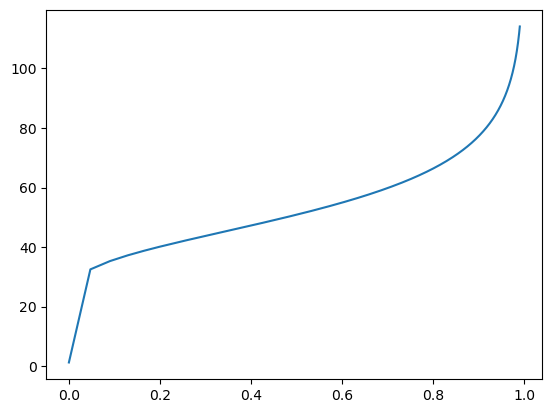

In [51]:
plt.plot(Fi2, test)

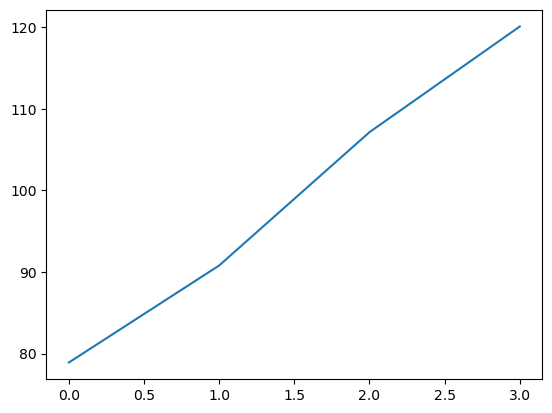

In [42]:
plt.plot(downres['mev_d'])

In [19]:
TEST = down.grid_corr(box_3h, plot=True, thresh=1)

In [31]:
down.fit_yearly_weibull(box_3h[0,0,:], thresh=1, maxmiss=36)

(array([[119.        ,   4.56476663,   0.7468582 ],
        [137.        ,   6.24496014,   0.77211353],
        [ 88.        ,   5.80960875,   0.80224674],
        [131.        ,   5.51856443,   0.82325847],
        [113.        ,   5.3810123 ,   0.70593653],
        [ 97.        ,   4.49089579,   0.70567503],
        [101.        ,   4.9452293 ,   0.72150721],
        [123.        ,   4.98583013,   0.71219941],
        [121.        ,   5.52546269,   0.77704804],
        [132.        ,   7.44677795,   0.94238523],
        [ 85.        ,   5.09176247,   0.68461593],
        [100.        ,   5.10624082,   0.68023333],
        [139.        ,   5.61801615,   0.74917976]]),
 array([2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008., 2009.,
        2010., 2011., 2012., 2013.]))